# Model Selection in HyperOpt Space

In [47]:
# conda install -c conda-forge pyts
# conda install -c conda-forge mlflow
# conda install -c conda-forge hyperopt
# conda install -c conda-forge xgboost

/Users/haleighoeser/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

In [15]:
from pyts.classification import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

In [16]:
from pyts.datasets import load_coffee
X_train, X_test, y_train, y_test = load_coffee(return_X_y=True)

## Define HyperOpt parameters

In [24]:
def obj(args):
    np.random.seed(1234)
    model = Pipeline(steps=[('model', args['model'])])
    model.set_params(**args['params'])
    scores = cross_validate(model, X_train, y_train, scoring=('accuracy', 'f1_macro', 'precision_macro', 'recall_macro'))
    
    acc = scores['test_accuracy'].mean()
    
    del scores['fit_time']
    del scores['score_time']
    for metric in scores:
        mlflow.log_metric(metric, scores[metric].mean())
    return {'loss': -acc, 'scores': scores, 'status': STATUS_OK, 'params': args['params']}

algo = tpe.suggest
max_evals = 10
trials = Trials()

/Users/haleighoeser/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
search_space = hp.choice('classifiers', [
    {
        'model':KNeighborsClassifier(),
        'params':{
            'model__n_neighbors': hp.choice("knc.n_neighbors", range(2,10)),
            'model__algorithm': hp.choice("knc.algorithm", ['auto', 'ball_tree', 'kd_tree'])
        }
    }, {
        'model':LogisticRegression(),
        'params':{
            'model__penalty': hp.choice("lr.penalty", ['none', 'l2']),
            'model__C': hp.quniform("lr.C", 0.05, 1, 0.05)
        }
    }, {
        'model':XGBClassifier(),
        'params':{
            'model__max_depth': hp.choice("xgb.max_depth", range(3,10)),
            'model__learning_rate': hp.quniform("xgb.learning_rate", 0.01, 0.5, 0.01),
            'model__n_estimators': hp.choice("xgb.n_estimators", range(100, 1000, 100))
        }
    }, {
        'model':RandomForestClassifier().fit(X_train, y_train),
        'params':{
            'model__n_estimators': hp.choice("rf.n_estimators", range(100, 1000, 100)),
            'model__criterion': hp.choice("rf.criterion", ['gini', 'entropy']),
            'model__max_depth': hp.choice("rf.max_depth", range(3, 10))
        }
    }
])

## Log Model with MLflow

In [26]:
with mlflow.start_run() as run:
    best = fmin(
        fn=obj,
        space = search_space,
        max_evals = max_evals,
        algo = algo,
        trials = trials)
    best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]
    params = best_model['params']
    scores = best_model['scores']
    mlflow.log_params(params)
    
    clf = space_eval(search_space, best)
    mlflow.sklearn.log_model(clf, "model")
    
    for metric in scores:
        mlflow.log_metric(metric, scores[metric].mean())

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]


/Users/haleighoeser/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
run_id = run.info.run_id
run_uri = "runs:/{}/model".format(run_id)

In [36]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
model = mlflow.sklearn.load_model(run_uri)

In [38]:
model

{'model': RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=700),
 'params': {'model__criterion': 'gini',
  'model__max_depth': 8,
  'model__n_estimators': 400}}

/Users/haleighoeser/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


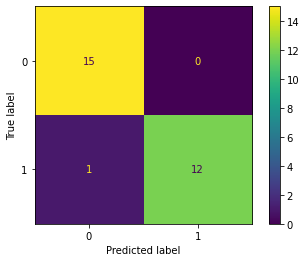

In [46]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model['model'], X_test, y_test)